# Preliminaries

#### Some important links
The Dataset from Kaggle - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

https://jayspeidell.github.io/portfolio/project05-toxic-comments/

https://developer.ibm.com/models/max-toxic-comment-classifier

Text Classification Algorithms: A Survey - https://github.com/kk7nc/Text_Classification

BERT - https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894

https://mccormickml.com/2019/07/22/BERT-fine-tuning/

http://jalammar.github.io/illustrated-bert/

#### Flags and constants

In [1]:
is_auto_eda = False # run sweetviz report
is_small_spacy = True
is_sample_df = True
sample_fraction = 0.1 # fraction of sampling from train and test DataFrames
num_epochs = 2 # number of epochs in BERT training loop (2-5)

#### Install packages

In [2]:
# needed for BERT model
!pip install -qq transformers # (-qq is for quite)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.1 MB/s eta 0:00:00


In [ ]:
# !pip install autocorrect # (TODO: add spell checking?)

#### Import Statements

In [54]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

import spacy
import spacy.cli
from spacy.lang.en.stop_words import STOP_WORDS

# for spaCy Text Categorizer
from spacy.util import minibatch, compounding
from spacy.training.example import Example

from wordcloud import WordCloud # See : https://www.kaggle.com/aashita/word-clouds-of-various-shapes

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from transformers import BertTokenizer, BertForSequenceClassification

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn.functional as F # for softmax in Eval

from datetime import datetime
import pytz # timezone

from tqdm import trange # used to make our loops show a smart progress meter

# from autocorrect import spell # (TODO: do we really need this?)

#torch.manual_seed(0)

print("Using PyTorch version", torch.__version__)

Using PyTorch version 2.0.1+cu118


#### Set pandas options

In [4]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns",100)
pd.set_option("display.max_colwidth", 500)
color = sns.color_palette() # (TODO: what does this line do and do we need it?)

#### Set torch GPU device

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu") # (TODO: change "cpu" to "device error"?)
device

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


device(type='cuda')

#### Download spaCy pretrained (existing) language model and load nlp object

In [6]:
if is_small_spacy:
  spacy.cli.download("en_core_web_sm")
  nlp = spacy.load('en_core_web_sm')
else:
  spacy.cli.download("en_core_web_lg")
  nlp = spacy.load('en_core_web_lg')

# nlp = spacy.blank('en') # new model

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### Mount drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### List directory

In [8]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'HIT/NLP'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

/content/drive/My Drive/HIT/NLP
['train.csv', 'test.csv', 'sample_submission.csv', 'test_labels.csv', 'old', 'NLP_Toxic_Comments_sweetviz.html', 'BERT', 'NLP_Project_Toxic_Comments_v1.4.0.ipynb']


In [9]:
os.chdir(GOOGLE_DRIVE_PATH)

# Read Data

#### A brief definition of the six different toxicity types

**Toxic**: very bad, unpleasant, or harmful

**Severe toxic**: extremely bad and offensive

**Obscene**: (of the portrayal or description of sexual matters) offensive or disgusting by accepted standards of morality and decency

**Threat**: a statement of an intention to inflict pain, injury, damage, or other hostile action on someone in retribution for something done or not done

**Insult**: speak to or treat with disrespect or scornful abuse

**Identity hate**: hatred, hostility, or violence towards members of a race, ethnicity, nation, religion, gender, gender identity, sexual orientation or any other designated sector of society

In [10]:
df = pd.read_csv('train.csv')
print(df.shape)
df

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0,0,0,0,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


#### Check for missing values - There are none

In [15]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

#### Check for duplicates - There are none

In [16]:
df.duplicated().sum()

0

#### Descriptive Statistics

In [17]:
df.describe(include='all')

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571,159571,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
unique,159571,159571,NaN,NaN,NaN,NaN,NaN,NaN
top,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,NaN,NaN,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Automated and Fast EDA - Using Sweetviz



https://towardsdatascience.com/fast-eda-in-jupyter-colab-notebooks-using-sweetviz-2-0-99c22bcb3a1c

https://towardsdatascience.com/powerful-eda-exploratory-data-analysis-in-just-two-lines-of-code-using-sweetviz-6c943d32f34

In [11]:
if is_auto_eda:
  !pip install sweetviz

  import sweetviz as sv

  eda_report = sv.analyze(df) #, pairwise_analysis='off')
  eda_report.show_html('NLP_Toxic_Comments_sweetviz.html')

# EDA - Using Plotly for visualizations

In [71]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_names_with_non_toxic = ['non_toxic', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [13]:
sum_class_names = sorted(df[class_names].sum(), reverse=True)

#### Bar chart - Toxic comments Distribution

In [18]:
fig = px.bar(x=class_names, y=sum_class_names, title="Toxic comments Distribution")
fig.show()

In [19]:
df_orig = df.copy() # copy used for correlation matrix

In [20]:
df['toxic_class_count'] = df[class_names].sum(axis=1) # count how many toxic classes are 1
df['is_toxic'] = (df['toxic_class_count']>0).astype(int)

In [26]:
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_class_count,is_toxic
106681,3a9677e27ca99c25,"No it was very much so vandalism. Do not edit like that again or I contact the police and report you over this matter. Thanks,",0,0,0,0,0,0,0,0
3025,082934bfa5eed031,"""\nStupid Vikings. A creative, new way to lose. Instead of a run play to center the ball and kick the winning FG with time expiring, let's have the ol' man throw across his body to his blind side and get picked off and force OT and hand the game to the Aints. Creative. As I've always maintain, the vikings always find a way to lose. | 76 """,1,0,0,0,1,0,2,1
144738,118fed5b15b93cd0,"""\n\nbad faith exhibited:\n\nTerms like """"fundie"""" and linking BSF to a political movement the Christian Right which has done some good things but some stupid things also, it shows bad faith. Calling me a Bible literalist even though I explicitly said I was not is bad faith. MickWest making imperious edits over and over again until you are told to stop by Mark that is bad faith. Duncharrris not acknowledging my excellent sources like medical historians, etc is bad faith. \n\nNot followin...",0,0,0,0,0,0,0,0
46912,7d5ec59ad16b64ce,The only thing not speculative in that article is that the Assembly was suspended.,0,0,0,0,0,0,0,0
2144,05ca53f49434e9aa,"Bob Lynch (comics) \n\nThat article is created by Bob Lynch himself, which is a clear violation of Wikipedia policies. Also, no, the proposed deletion has not been declined. Is Bob Lynch your friend? The image that you deleted is that of Bob Lynch himself, so it has a direct relation to the article that should be deleted anyhow.",0,0,0,0,0,0,0,0


In [27]:
is_toxic_value_counts = df['is_toxic'].value_counts()
is_toxic_value_counts

0    143346
1     16225
Name: is_toxic, dtype: int64

#### Pie chart - Toxic / Non-Toxic

In [28]:
fig = px.pie(is_toxic_value_counts, values='is_toxic', names=['Non-Toxic', 'Toxic'], width=600, title='Is toxic')
fig.show()

In [29]:
toxic_class_value_counts = df['toxic_class_count'].value_counts()
toxic_class_value_counts

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: toxic_class_count, dtype: int64

In [30]:
class_name_index = [f"class count {i}" for i in range(len(class_names_with_non_toxic))]
class_name_index

['class count 0',
 'class count 1',
 'class count 2',
 'class count 3',
 'class count 4',
 'class count 5',
 'class count 6']

#### Pie chart - Toxic commments class count

In [31]:
fig = px.pie(toxic_class_value_counts, values='toxic_class_count', names=class_name_index, width=600, title='Toxic commments class count')
fig.show()

#### Pearson Correlation Matrix

In [32]:
corr = df_orig.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask).round(decimals = 2)

fig = ff.create_annotated_heatmap(z=df_mask.to_numpy(),
                              x=df_mask.columns.tolist(),
                              y=df_mask.columns.tolist(),
                              colorscale=px.colors.diverging.RdBu,
                              hoverinfo="none",  # Shows hoverinfo for null values
                              showscale=True, ygap=1, xgap=1
                              )

fig.update_xaxes(side="bottom")

fig.update_layout(
  title_text='Correlations Matrix Heatmap',
  title_x=0.5,
  width=1000,
  height=1000,
  xaxis_showgrid=False,
  yaxis_showgrid=False,
  xaxis_zeroline=False,
  yaxis_zeroline=False,
  yaxis_autorange='reversed',
  template='plotly_white'
)

# NaN values are not handled automatically and are displayed in the figure
# So we need to get rid of the text manually
for i in range(len(fig.layout.annotations)):
  if fig.layout.annotations[i].text == 'nan':
      fig.layout.annotations[i].text = ""

fig.show()

<ipython-input-32-7ab621a800c3>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



# Sampling the Train DataFrame if flag is True

In [33]:
if is_sample_df:
  print("frac =",sample_fraction)
  df_to_preprocess = df.sample(frac=sample_fraction, random_state=42)
else:
  df_to_preprocess = df.copy()
df_to_preprocess.shape

frac = 0.1


(15957, 10)

# Preprocessing Data - Using SpaCy

#### Creating spaCy DOC object

In [34]:
# example:
doc = nlp("These are my words of one sentence.")
for token in doc:
  print(token.text, token.pos_, token.dep_) # pos = part of speech, dep = dependency

These PRON nsubj
are AUX ROOT
my PRON poss
words NOUN attr
of ADP prep
one NUM nummod
sentence NOUN pobj
. PUNCT punct


In [35]:
# list of Doc objects
%%time
df_to_preprocess['preprocessed_text'] = list(nlp.pipe(df_to_preprocess['comment_text']))

# This is the faster version of:
# df_to_preprocess['preprocessed_text'] = [nlp(text) for text in df_to_preprocess['comment_text']]

CPU times: user 2min 24s, sys: 1.1 s, total: 2min 25s
Wall time: 2min 32s


#### Cleaning and Lemmatizing text

In [36]:
def clean_doc(doc):
  list_clean_tokens =  [token for token in doc if
              not token.is_punct # punctuation
              and not token.is_currency
              and not token.is_digit
              # and not token.is_oov # Is the token out-of-vocabulary (i.e. does it not have a word vector)?
              and not token.is_space # Does the token consist of whitespace characters? Equivalent to token.text.isspace().
              and not token.is_stop
              and not token.like_num
              and not token.like_url and ('@' not in token.text) and ('|' not in token.text)
              # and not token.pos_ == "PROPN" ("Wikipedia")
              ]
  return list_clean_tokens

# Lemmatizing + to lower case
def lemma_text(doc):
    tokens=[]
    for token in doc:
        if token.lemma_ != "-PRON-":
            lemma = token.lemma_.lower().strip()
        else:
            lemma = token.lower_
        tokens.append(lemma)
    return tokens

#create_string
def create_string(doc):
  new_string = ' '.join([str(token) for token in doc])
  return new_string

In [37]:
def preprocess_all(df):
    df['preprocessed_text'] = df['preprocessed_text'].apply(clean_doc)
    df['preprocessed_text'] = df['preprocessed_text'].apply(lemma_text)
    df['preprocessed_text'] = df['preprocessed_text'].apply(create_string)
    return df

In [38]:
df_preprocessed = preprocess_all(df_to_preprocess)

In [39]:
df_preprocessed[['comment_text','preprocessed_text', 'is_toxic']].head()

,comment_text,preprocessed_text,is_toxic
119105,"Geez, are you forgetful! We've already discussed why Marx was not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.' Ergo, he is a statist - the opposite of an anarchist. I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat. Would you call him a vegetarian?",geez forgetful discuss marx anarchist i.e. want use state mold socialist man ergo statist opposite anarchist know guy say get old tooth fall quit eat meat vegetarian,0
131631,"Carioca RFA \n\nThanks for your support on my request for adminship.\n\nThe final outcome was (31/4/1), so I am now an administrator. If you have any comments or concerns on my actions as an administrator, please let me know. Thank you!",carioca rfa thank support request adminship final outcome 31/4/1 administrator comment concern action administrator let know thank,0
125326,"""\n\n Birthday \n\nNo worries, It's what I do ;)Enjoy ur day|talk|e """,birthday worry enjoy ur,0
111256,"Pseudoscience category? \n\nI'm assuming that this article is in the pseudoscience category because of its association with creationism. However, there are modern, scientifically-accepted variants of catastrophism that have nothing to do with creationism — and they're even mentioned in the article! I think the connection to pseudoscience needs to be clarified, or the article made more general and less creationism-specific and the category tag removed entirely.",pseudoscience category assume article pseudoscience category association creationism modern scientifically accept variant catastrophism creationism mention article think connection pseudoscience need clarify article general creationism specific category tag remove entirely,0
83590,"(and if such phrase exists, it would be provided by search engine even if mentioned page is not available as a whole)",phrase exist provide search engine mention page available,0


# Word Cloud

See : https://www.kaggle.com/aashita/word-clouds-of-various-shapes

In [40]:
def plot_wordcloud(text, mask=None, figure_size=(15.0,10.0),
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(stopwords=STOP_WORDS,background_color='white',
                    random_state = 42,
                    width=800,
                    height=400,
                    mask = mask,
                    collocations=False) # Do not repeat words in the cloud
    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

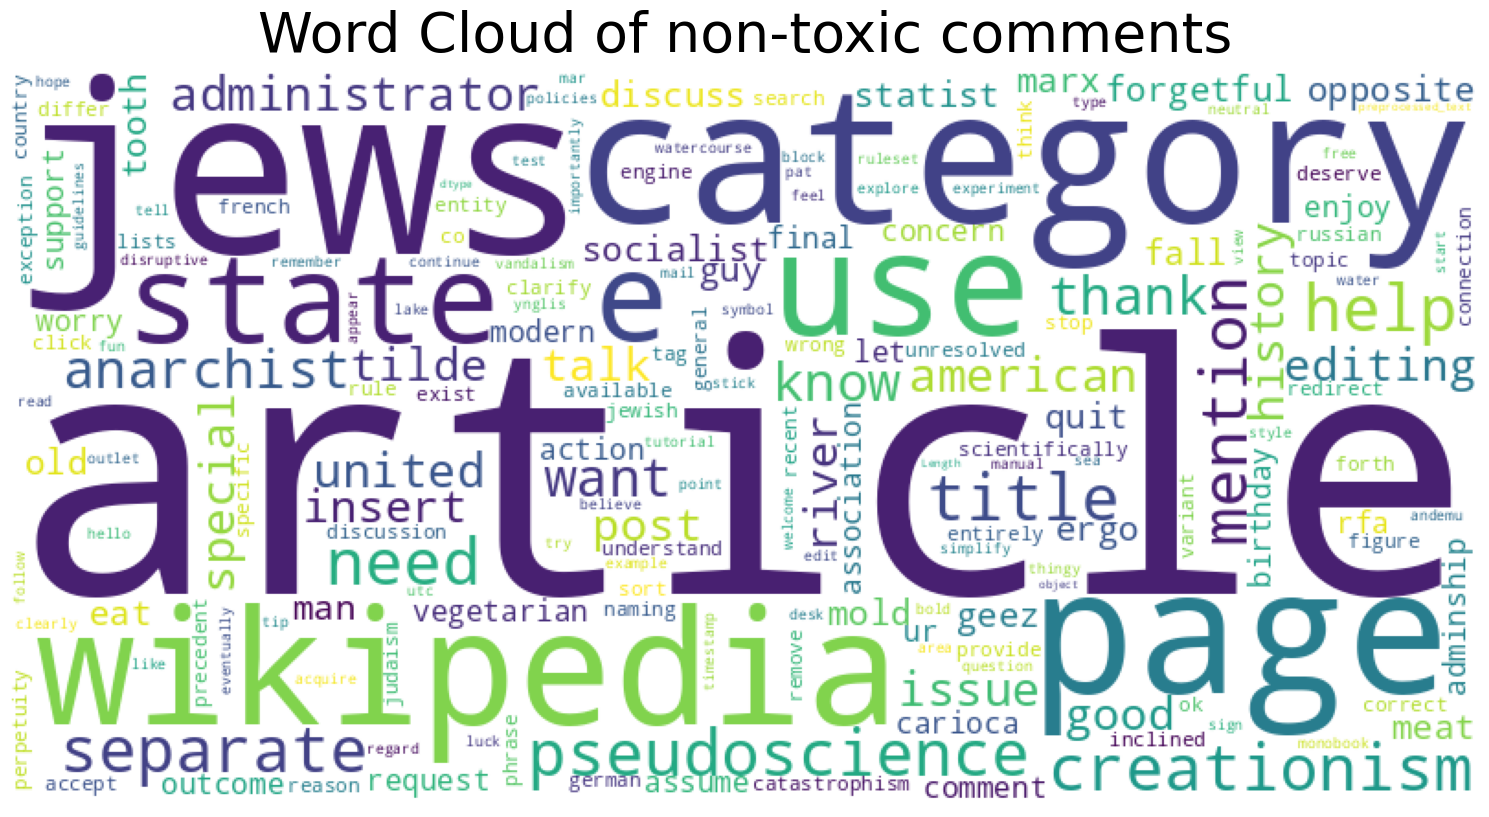

In [41]:
plot_wordcloud(df_preprocessed[df_preprocessed['is_toxic']==0]['preprocessed_text'], title="Word Cloud of non-toxic comments")

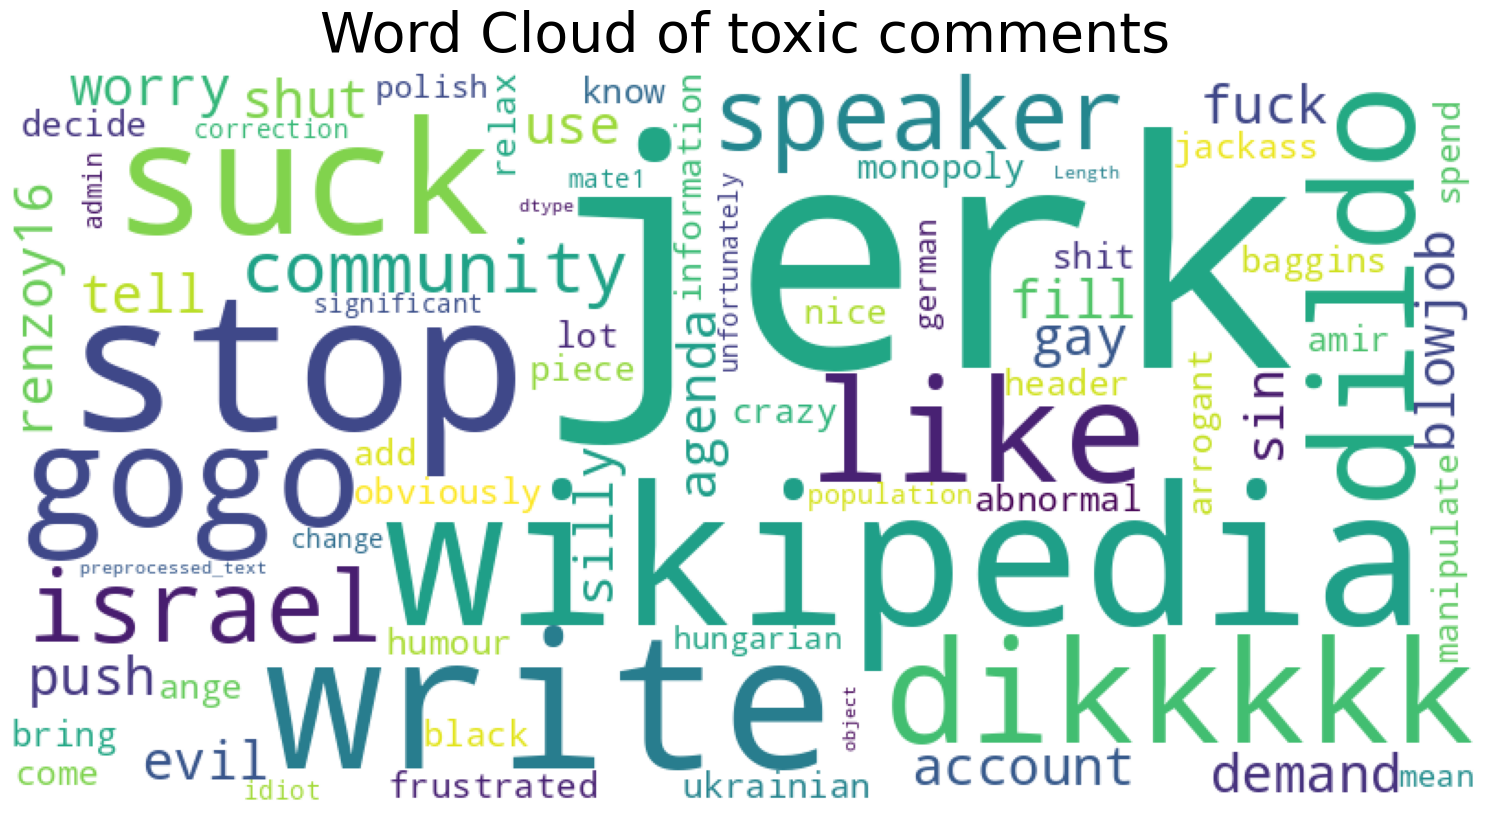

In [42]:
plot_wordcloud(df_preprocessed[df_preprocessed['is_toxic']==1]['preprocessed_text'], title="Word Cloud of toxic comments")

# Prepare for models

In [43]:
X = df_preprocessed['preprocessed_text']
y = df_preprocessed['is_toxic']

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [45]:
# Prepare data
train_texts = X_train.to_list()  # List of training text samples
train_labels = y_train.to_list()  # List of training labels (0 for non-toxic, 1 for toxic)

val_texts = X_val.to_list()  # List of val text samples
val_labels = y_val.to_list()  # List of val labels (0 for non-toxic, 1 for toxic)

#### Print results function

In [46]:
target_names = ['Non-toxic', 'Toxic']

def print_results(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1-score: {f1:.4f}')

  # Classification Report
  report = classification_report(y_true, y_pred, target_names=target_names)
  print(f"\nClassification Report:\n{report}")

  # Confusion Matrix
  cm = confusion_matrix(y_true, y_pred)
  print('Confusion Matrix:')
  print(cm)

# Models

#### Vectorize the text using TF-IDF vectorizer (Term Frequency-Inverse Document Frequency)

In [47]:
max_features=10000

vectorizer = TfidfVectorizer(max_features=max_features)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

# Logistic Regression

In [48]:
# Train the logistic regression classifier
log_reg_classifier = LogisticRegression()
log_reg_classifier.fit(X_train_vec, y_train)

# Predict on the val set
y_pred = log_reg_classifier.predict(X_val_vec)

# Evaluate the model
print("Logistic Regression:")
print_results(y_val, y_pred)

Logistic Regression:
Accuracy: 0.9367
Precision: 0.9669
Recall: 0.3714
F1-score: 0.5367

Classification Report:
              precision    recall  f1-score   support

   Non-toxic       0.94      1.00      0.97      2877
       Toxic       0.97      0.37      0.54       315

    accuracy                           0.94      3192
   macro avg       0.95      0.69      0.75      3192
weighted avg       0.94      0.94      0.92      3192

Confusion Matrix:
[[2873    4]
 [ 198  117]]


# Linear SVC (Support Vector Classifier)

In [49]:
# Train the LinearSVC classifier
svc_classifier = LinearSVC() # (TODO: random_state=42, dual=False, max_iter=1000)
svc_classifier.fit(X_train_vec, y_train)

# Predict on the val set
y_pred = svc_classifier.predict(X_val_vec)

# Evaluate the model
print("LinearSVC:")
print_results(y_val, y_pred)

LinearSVC:
Accuracy: 0.9489
Precision: 0.8455
Recall: 0.5905
F1-score: 0.6953

Classification Report:
              precision    recall  f1-score   support

   Non-toxic       0.96      0.99      0.97      2877
       Toxic       0.85      0.59      0.70       315

    accuracy                           0.95      3192
   macro avg       0.90      0.79      0.83      3192
weighted avg       0.95      0.95      0.94      3192

Confusion Matrix:
[[2843   34]
 [ 129  186]]


# MultinomialNB (Naive Bayes)

In [50]:
# Train the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# Predict on the val set
y_pred = nb_classifier.predict(X_val_vec)

# Evaluate the model
print("Multinomial Naive Bayes:")
print_results(y_val, y_pred)

Multinomial Naive Bayes:
Accuracy: 0.9258
Precision: 1.0000
Recall: 0.2476
F1-score: 0.3969

Classification Report:
              precision    recall  f1-score   support

   Non-toxic       0.92      1.00      0.96      2877
       Toxic       1.00      0.25      0.40       315

    accuracy                           0.93      3192
   macro avg       0.96      0.62      0.68      3192
weighted avg       0.93      0.93      0.90      3192

Confusion Matrix:
[[2877    0]
 [ 237   78]]


# BERT (Bidirectional Encoder Representations from Transformers)

#### Some more links about BERT

https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=PGnlRWvkY-2c

In [51]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 512 # (TODO: change to 128? or something else?)
BATCH_SIZE = 16
NUM_CLASSES = 2 # Toxic, Non-Toxic

#### Load BERT tokenizer

In [52]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case = True)

#### Measure max sentence length, Plot Histogram

Before we are ready to encode our text, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [55]:
max_sentence_len_tokens = 0
input_ids_lens = []

# For every sentence...
for sentence in df_preprocessed['preprocessed_text']:

    # Tokenize the text and add `[CLS]` (sentence start), and `[SEP]` (sentence end) tokens.
    input_ids = tokenizer.encode(sentence, add_special_tokens = True) # (TODO: add max_length=512, truncation=True if needed)

    # append to list of lens
    input_ids_lens.append(len(input_ids))

    # Update the maximum sentence length.
    max_sentence_len_tokens = max(max_sentence_len_tokens, len(input_ids))

print('Max sentence length (tokens):', max_sentence_len_tokens)
print('Total number of tokens in all sentences (including special tokens):', sum(input_ids_lens))

# Old - Seaborn
# sns.histplot(input_ids_lens)
# plt.xlim([0, 400])
# plt.xlabel('Number of tokens in a sentence')
# plt.title("Num tokens Histogram");

# Use Plotly instead of Seaborn
fig = go.Figure(data=[go.Histogram(x=input_ids_lens)])
fig.update_layout(
    xaxis=dict(title='Number of tokens in a sentence'),
    yaxis=dict(title='Count'),
    title="Num tokens Histogram",
    bargap=0.1
)
fig.show()

Max sentence length (tokens): 1987
Total number of tokens in all sentences (including special tokens): 618659


In [56]:
# Tokenize and encode the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LEN)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAX_LEN)

#### Defining Custom Dataset class

In [57]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, index):
        item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[index])
        return item

    def __len__(self):
        return len(self.labels)

#### Create DataLoaders

In [58]:
train_dataset = ToxicCommentsDataset(train_encodings, train_labels)
val_dataset = ToxicCommentsDataset(val_encodings, val_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### Load pre-trained BERT model (BertForSequenceClassification)

In [59]:
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    num_labels = NUM_CLASSES,
    output_attentions = False,
    output_hidden_states = False,
)

# we don't need this really: model.classifier = nn.Linear(in_features=model.config.hidden_size, out_features=NUM_CLASSES)

model = model.to(device)

print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#### Set optimizer and loss function

Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf

In [60]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-08) # (TODO: play with hyperparameters: lr = 5e-5, eps = 1e)

loss_func = nn.CrossEntropyLoss()

#### Training loop

In [61]:
%%time
model.train()  # Set the model to training mode
'''
The model.train() function is typically used in PyTorch to set the model in training mode.
When you call model.train(), it activates certain modules in the model that behave differently during training compared to evaluation/testing.
These modules include dropout and batch normalization layers.
During training, dropout layers randomly set a fraction of their inputs to zero,
which helps in regularization and prevents overfitting.
Batch normalization layers calculate batch-wise statistics and normalize the inputs, aiding in faster convergence and improved generalization.
By default, PyTorch sets the model to training mode when you create an instance of it.
However, it's good practice to call model.train() explicitly before the training loop to ensure that the model is indeed in the training mode.
'''
timezone = pytz.timezone('Asia/Jerusalem')

for epoch in trange(num_epochs):
    time_str = datetime.now().astimezone(timezone).strftime("%d-%m-%Y-%H:%M:%S")
    print(time_str)
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        #loss = outputs.loss (this line was before using loss_func)
        logits = outputs.logits
        loss = loss_func(logits, labels)

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}')


  0%|          | 0/2 [00:00<?, ?it/s]

28-06-2023-15:24:00


 50%|█████     | 1/2 [19:00<19:00, 1140.99s/it]

Epoch 1/2 - Loss: 0.1353
28-06-2023-15:43:01


100%|██████████| 2/2 [38:02<00:00, 1141.43s/it]

Epoch 2/2 - Loss: 0.0704
CPU times: user 37min 24s, sys: 5.45 s, total: 37min 29s
Wall time: 38min 2s


#### Save trained model

In [ ]:
# we will use the PyTorch internal storage functions
#torch.save(model, "BERT")

# you can reload model with all the weights and so forth with:
#model = torch.load("BERT")

#### Evaluation

In [92]:
def evaluate(data_loader):
  # Put the model into evaluation mode which disables dropout and batch normalization layers
  model.eval()
  '''
  After the training loop, you can call model.eval() to switch the model to evaluation mode.
  In evaluation mode, the behavior of dropout and batch normalization layers changes.
  Dropout layers no longer drop inputs, and batch normalization layers use the running statistics computed during training instead of calculating batch-wise statistics.
  It's essential to set the model to the appropriate mode (train() or eval()),
  as it ensures that the correct behavior is applied to the model's modules during training and evaluation/testing, respectively.
  '''
  y_true = []
  y_pred = []

  # The torch.no_grad() context ensures that gradients are not computed during testing, which reduces memory usage and speeds up inference
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask)

      # this line was before using softmax
      #_, predicted = torch.max(outputs.logits, dim=1)

      # Obtain the model's logits
      logits = outputs.logits

      # Add softmax activation function to obtain the probabilities for each class.
      # Note that softmax is typically used during inference or evaluation to obtain class probabilities.
      # During training, the model usually directly outputs logits, and the loss function handles the conversion to probabilities.
      probabilities = F.softmax(logits, dim=1) # see https://www.pinecone.io/learn/train-sentence-transformers-softmax/

      # Use torch.max to get the predicted labels based on the highest probability
      _, predicted = torch.max(probabilities, dim=1)

      # 'labels' and 'predicted' are tensors, so we cast them to numpy arrays
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

  print("BERT model results:")
  print_results(y_true, y_pred)

  return y_true, y_pred

In [93]:
%%time
y_true, y_pred = evaluate(val_loader)

BERT model results:
Accuracy: 0.9649
Precision: 0.8418
Recall: 0.7937
F1-score: 0.8170

Classification Report:
              precision    recall  f1-score   support

   Non-toxic       0.98      0.98      0.98      2877
       Toxic       0.84      0.79      0.82       315

    accuracy                           0.96      3192
   macro avg       0.91      0.89      0.90      3192
weighted avg       0.96      0.96      0.96      3192

Confusion Matrix:
[[2830   47]
 [  65  250]]
CPU times: user 1min 47s, sys: 110 ms, total: 1min 47s
Wall time: 1min 49s


In [94]:
# create the colorful confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize confusion matrix
z = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Ensure the matrix is in the list of lists format
z = z.tolist()
binary_class_names = ['non toxic', 'toxic']

fig = px.imshow(z, labels=dict(x="Predicted label", y="True label", color="Rate"), x=binary_class_names, y=binary_class_names, text_auto=True, width=650)
fig.show()

#### Prediction

In [95]:
df_test = pd.read_csv('test.csv') # 'id' and 'comment_text'
df_test_labels = pd.read_csv('test_labels.csv') # 'id' and 6 binary toxic labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)
df_test_merged = pd.merge(df_test, df_test_labels, on='id')
print(df_test.shape, df_test_labels.shape)

(153164, 2) (153164, 7)


In [96]:
# sum toxic labels
df_test_merged['toxic_class_count'] = df_test_merged[class_names].sum(axis=1)
# filter rows with labels == -1
df_test_merged = df_test_merged[df_test_merged['toxic_class_count']>=0]
# add 'is_toxic' feature
df_test_merged['is_toxic'] = (df_test_merged['toxic_class_count']>0).astype(int)
print(df_test_merged.shape)

(63978, 10)


#### Sampling the Test DataFrame if flag is True

In [97]:
if is_sample_df:
  print("frac =",sample_fraction)
  df_test_to_preprocess = df_test_merged.sample(frac=sample_fraction, random_state=42)
else:
  df_test_to_preprocess = df_test_merged.copy()
df_test_to_preprocess.shape

frac = 0.1


(6398, 10)

In [98]:
# list of Doc objects
%%time
df_test_to_preprocess['preprocessed_text'] = list(nlp.pipe(df_test_to_preprocess['comment_text']))

# This is the faster version of:
# df_test_to_preprocess['preprocessed_text'] = [nlp(text) for text in df_test_to_preprocess['comment_text']]

CPU times: user 49.1 s, sys: 300 ms, total: 49.4 s
Wall time: 49.6 s


In [99]:
df_test_preprocessed = preprocess_all(df_test_to_preprocess)

In [100]:
test_labels = df_test_preprocessed['is_toxic'].to_list()

In [101]:
# List of text samples for prediction
test_texts = df_test_preprocessed['preprocessed_text'].to_list()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=MAX_LEN)
test_dataset = ToxicCommentsDataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [102]:
%%time
y_true, y_pred = evaluate(test_loader)

BERT model results:
Accuracy: 0.9054
Precision: 0.5239
Recall: 0.8815
F1-score: 0.6572

Classification Report:
              precision    recall  f1-score   support

   Non-toxic       0.99      0.91      0.95      5740
       Toxic       0.52      0.88      0.66       658

    accuracy                           0.91      6398
   macro avg       0.75      0.89      0.80      6398
weighted avg       0.94      0.91      0.92      6398

Confusion Matrix:
[[5213  527]
 [  78  580]]
CPU times: user 3min 33s, sys: 225 ms, total: 3min 33s
Wall time: 3min 38s


# SpaCy TextCategorizer - Not Finished

In [ ]:
#nlp = spacy.load('en_core_web_sm')

In [ ]:
# Split the dataset into train and validation sets
train_data, val_data = train_test_split(df_preprocessed, test_size=0.2, random_state=42)

In [ ]:
print("nlp.pipe_names:", nlp.pipe_names)

# Add the text categorizer to the nlp object pipeline if it doesn't exist
if 'textcat' not in nlp.pipe_names:
    print("Adding textcat to nlp pipeline")

    nlp.add_pipe('textcat', last=True)

    print("nlp.pipe_names:", nlp.pipe_names)

textcat = nlp.get_pipe('textcat')

# Add the labels to the text categorizer
#labels = ['Non-toxic', 'Toxic']
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for label in labels:
    textcat.add_label(label)
print("labels:",textcat.labels)

nlp.pipe_names: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
Adding textcat to nlp pipeline
nlp.pipe_names: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'textcat']
labels: ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')


#### Train the model

In [ ]:
train_texts = train_data['preprocessed_text'].tolist()
train_labels = [{label: bool(row[label]) for label in labels} for _, row in train_data.iterrows()]
train_data_zipped = list(zip(train_texts, [{"cats": label} for label in train_labels]))

In [ ]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat_multilabel"]
with nlp.disable_pipes(*other_pipes): # only train textcat
    optimizer = nlp.create_optimizer()
    print("Training the textcat model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'Precision', 'Recall', 'F1-score'))
    for i in range(20):
        random.shuffle(train_data_zipped)
        losses = {}
        # batch up the examples using spaCy's minibatch
        for batch in minibatch(train_data_zipped, size=8): # size=compounding(4., 32., 1.001))
            texts, annotations = zip(*batch)

            example = []
            # Update the model with iterating each text
            for j in range(len(texts)):
                doc = nlp.make_doc(texts[j])
                example.append(Example.from_dict(doc, annotations[j]))
            # StackOverFlow:
            #nlp.update(example, drop=0.5, losses=losses)
            nlp.update(example, sgd=optimizer, drop=0.2, losses=losses)

            # wrong
            #nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
            #           losses=losses)
            #nlp.update(texts, annotations, sgd=optimizer, losses=losses)
        print(f"Epoch {i+1}: Losses {losses}")

Training the textcat model...
LOSS 	Precision	Recall	F1-score
Epoch 1: Losses {}
Epoch 2: Losses {}
Epoch 3: Losses {}
Epoch 4: Losses {}
Epoch 5: Losses {}
Epoch 6: Losses {}
Epoch 7: Losses {}
Epoch 8: Losses {}
Epoch 9: Losses {}
Epoch 10: Losses {}
Epoch 11: Losses {}
Epoch 12: Losses {}
Epoch 13: Losses {}
Epoch 14: Losses {}
Epoch 15: Losses {}
Epoch 16: Losses {}
Epoch 17: Losses {}
Epoch 18: Losses {}
Epoch 19: Losses {}
Epoch 20: Losses {}


#### Evaluate the model

In [ ]:
test_texts = val_data['preprocessed_text'].tolist()
test_labels = [{label: bool(row[label]) for label in labels} for _, row in val_data.iterrows()]
test_data_zipped = list(zip(test_texts, [{"cats": label} for label in test_labels]))

docs = [nlp(text) for text, _ in test_data_zipped]
predicted_labels = [doc.cats for doc in docs]
true_labels = [label for _, label in test_data_zipped]

print(classification_report(true_labels, predicted_labels, target_names=labels))